In [1]:
#Using NLP to detect tweets related to natural distasters. See https://www.kaggle.com/donmarch14/disaster-tweets-prediction-nlp-guide

#This code preprocesses the data, then compares combinations of data representation models and machine learning algorithms. 

#Data representation models: Word Embedding, Bag of Words, TF IDF
#ML models: SVG, XGB Boost, Naive Bayes Classifier, Logistic Regression Classifier

import numpy as np
import pandas as pd
import os

import string
import emoji
import re

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from tensorflow.keras.layers import Dense, Input
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.stem.snowball import SnowballStemmer

import numpy as np 
import pandas as pd
import os

import string
import emoji
import re

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
from tensorflow.keras.layers import Dense, Input
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud



# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

#For Stemming, NLTK is needed
import nltk
from nltk.stem.snowball import SnowballStemmer

import spacy
nlp = spacy.load('en_core_web_lg')

In [2]:
#load datasets
raw_data_train = pd.read_csv('./Downloads/nlp-getting-started/train.csv')
raw_data_test = pd.read_csv('./Downloads/nlp-getting-started/test.csv')

In [3]:
#Exploratory data analysis

#Check for NaN values
raw_data_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
raw_data_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [5]:
#Find number of words in tweets
word_count = raw_data_train['text'].str.split().str.len()
word_count
print(max(word_count))

31


In [6]:
raw_data_train[raw_data_train.keyword.isnull()==False]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [7]:
#Check shape of datasets
print("Train dataset shape: ", raw_data_train.shape)
print("Test dataset shape: ", raw_data_test.shape)

Train dataset shape:  (7613, 5)
Test dataset shape:  (3263, 4)


In [8]:
#Check how many disaster-related tweets there are
raw_data_train['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

In [9]:
#View keywords
raw_data_train['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
body%20bags              41
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

<AxesSubplot:xlabel='keyword'>

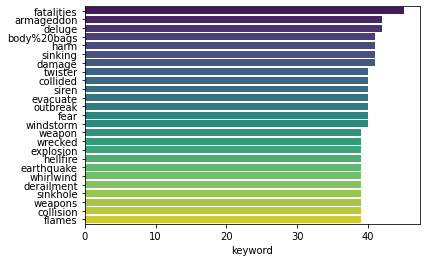

In [10]:
sns.barplot(y=raw_data_train['keyword'].value_counts()[:25].index,x=raw_data_train['keyword'].value_counts()[:25], orient='horizontal', palette='viridis')

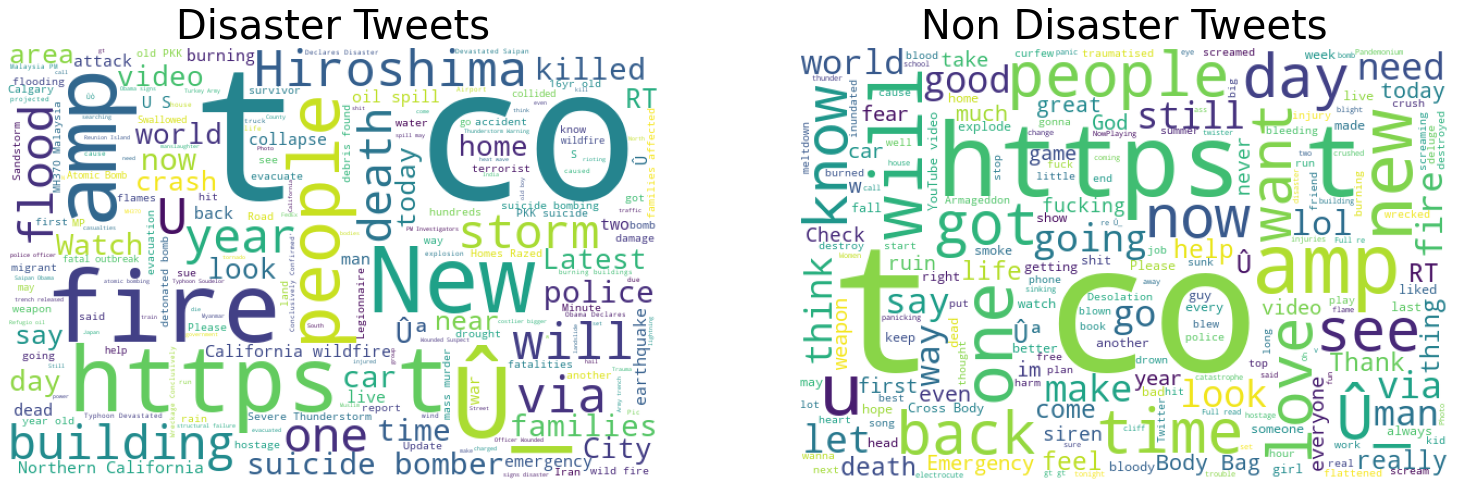

In [11]:
#Create word clouds for disaster and non-disaster related tweets
disaster_tweets = raw_data_train[raw_data_train['target']==1]['text']
non_disaster_tweets = raw_data_train[raw_data_train['target']==0]['text']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

In [12]:
#Preprocess the data
def clean(text):
    text = text.lower()
    text = removeStopwords(text)
    text = removePunctuations(text)
    text = removeEmojis(text)
    text = removeNumbers(text)
    text = removeLinks(text)
    return text

In [13]:
def removeStopwords(text):
    doc = nlp(text)
    clean_text = ' '
    for txt in doc:
        if (txt.is_stop == False):
            clean_text = clean_text + " " + str(txt)        
    
    return clean_text

print("Text before removeStopwords function: " + raw_data_train['text'][1])
print("Text after removeStopwords function: " + removeStopwords(raw_data_train['text'][1]))

Text before removeStopwords function: Forest fire near La Ronge Sask. Canada
Text after removeStopwords function:   Forest fire near La Ronge Sask . Canada


In [14]:
def removePunctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

print("Text before removePunctuations function: " + raw_data_train['text'][1])
print("Text after removePunctuations function: " + removePunctuations(raw_data_train['text'][1]))

Text before removePunctuations function: Forest fire near La Ronge Sask. Canada
Text after removePunctuations function: Forest fire near La Ronge Sask Canada


In [15]:
def removeEmojis(text):
    allchars = [c for c in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI["en"]]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

test_string = "Hi' 🤔 How is your 🙈 and 😌. Have a nice weekend 💕👭👙".lower()
(test_string,removeEmojis(test_string))

("hi' 🤔 how is your 🙈 and 😌. have a nice weekend 💕👭👙",
 "hi' how is your and have a nice weekend")

In [16]:
def removeNumbers(text):
    clean_text = re.sub(r'\d+', '', text)
    return clean_text

test_string = "Hi 🙈 99 girls are running"
(test_string,removeNumbers(test_string))

('Hi 🙈 99 girls are running', 'Hi 🙈  girls are running')

In [17]:
def removeLinks(text):
    clean_text = re.sub('https?://\S+|www\.\S+', '', text)
    #https? will match both http and https
    #A|B, where A and B can be arbitrary REs, creates a regular expression that will match either A or B.
    #\S Matches any character which is not a whitespace character.
    #+ Causes the resulting RE to match 1 or more repetitions of the preceding RE. ab+ will match ‘a’ followed by any non-zero number of ‘b’s; it will not match just ‘a’.
    return clean_text

test_string = "http://www.youtube.com/ and https://www.youtube.com/ should be removed "
(test_string,removeLinks(test_string))

('http://www.youtube.com/ and https://www.youtube.com/ should be removed ',
 ' and  should be removed ')

In [18]:
raw_data_train['text']=raw_data_train.text.apply(clean)
raw_data_test['text']=raw_data_test.text.apply(clean)

In [19]:
raw_data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake allah forgive,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


Text(0.5, 1.0, 'Tweets')

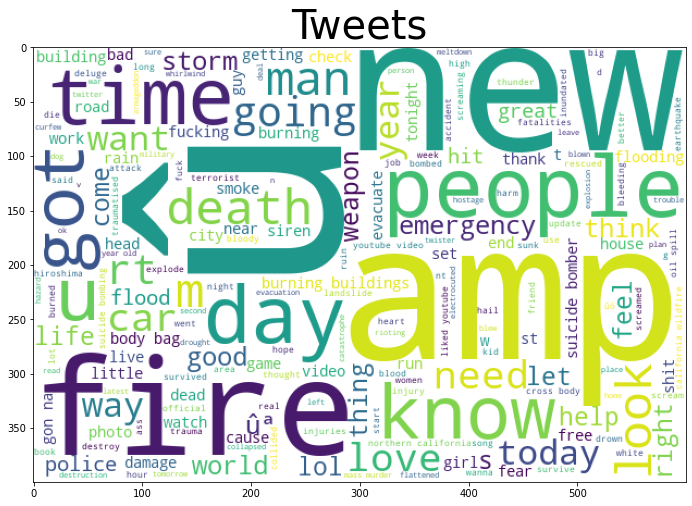

In [20]:
tweets = raw_data_train['text']
fig, ax1, = plt.subplots(1, figsize=[26,8])
wordcloud1 = WordCloud(background_color='white', width=600, height=400).generate(" ".join(tweets))
ax1.imshow(wordcloud1)
ax1.axis('on')
ax1.set_title('Tweets', fontsize=40)

In [21]:
#Fix inaccuracies in the data (https://www.kaggle.com/rftexas/text-only-bert-keras?scriptVersionId=31186559)
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
raw_data_train.at[raw_data_train['id'].isin(ids_with_target_error),'target'] = 0
raw_data_train[raw_data_train['id'].isin(ids_with_target_error)]

,id,keyword,location,text,target
229,328,annihilated,NaN,ready annihilated bucs game,0
301,443,apocalypse,NaN,short reading apocalypse spirit angel took en...,0
356,513,army,Studio,build army dogs leader lion dogs fight like lion,0
1822,2619,crashed,NaN,ipod crashed weloveyoulouis mtvhottest direction,0
2536,3640,desolation,"Quilmes , Arg",desperation dislocation separation condemnatio...,0
2715,3900,devastated,PG Chillin!,man currensy talkin talk devastated ghostwrite...,0
3024,4342,dust%20storm,chicago,going fest bring swimming goggles dust storm c...,0
4068,5781,forest%20fires,NaN,campsite recommendations toilets shower pub fi...,0
4609,6552,injury,Saint Paul,prediction vikings game sunday dont expect lot...,0
4611,6554,injury,NaN,dante exum knee injury stem jazz hoped surge h...,0


In [22]:
#Normalise the text (https://www.kaggle.com/rftexas/text-only-bert-keras?scriptVersionId=31186559)
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [23]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [24]:
raw_data_train['text'] = raw_data_train.text.apply(convert_abbrev)
raw_data_test['text'] = raw_data_test.text.apply(convert_abbrev)

In [25]:
stemmer = SnowballStemmer(language='english')

tokens = raw_data_train['text'][1].split()
clean_text = ' '

for token in tokens:
    print(token + ' --> ' + stemmer.stem(token))

forest --> forest
fire --> fire
near --> near
la --> la
ronge --> rong
sask --> sask
canada --> canada


In [26]:
#Stemming the data
def stemWord(text):
    stemmer = SnowballStemmer(language='english')
    tokens = text.split()
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + stemmer.stem(token)      
    
    return clean_text

print("Text before stemWord function: " + raw_data_train['text'][1])
print("Text after stemWord function: " + stemWord(raw_data_train['text'][1]))

Text before stemWord function: forest fire near la ronge sask canada
Text after stemWord function:   forest fire near la rong sask canada


In [27]:
raw_data_train['text'] = raw_data_train.text.apply(stemWord)
raw_data_test['text'] = raw_data_test.text.apply(stemWord)

In [28]:
for txt in raw_data_train.text[:40]:
    print(txt)

  deed reason earthquak allah forgiv
  forest fire near la rong sask canada
  resid ask shelter place notifi offic evacu shelter place order expect
  peopl receiv wildfir evacu order california
  got sent photo rubi alaska smoke wildfir pour school
  rockyfir updat california hwi close direct lake counti fire cafir wildfir
  flood disast heavi rain caus flash flood street manitou colorado spring area
  hill fire wood
  emerg evacu happen build street
  afraid tornado come area
  peopl die heat wave far
  haha south tampa get flood hah wait second live south tampa gon na gon na fvck flood
  rain flood florida tampabay tampa day lost count
  flood bago myanmar arriv bago
  damag school bus multi car crash break
  man
  love fruit
  summer love
  car fast
  goooooooaaaaaal
  ridicul
  london cool
  love ski
  wonder day
  looooool
  way eat shit
  nyc week
  love girlfriend
  cooool
  like pasta
  end
  bbcmtd wholesal market ablaz httptcolhyxeohyc
  tri bring heavi metal rt httptcoyaoexn

In [29]:
#lemmatisation
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for noun in doc.noun_chunks:
    print(noun.text)

Apple
U.K. startup


In [30]:
for word in doc:
    print(word.text, word.lemma_)

Apple Apple
is be
looking look
at at
buying buy
U.K. U.K.
startup startup
for for
$ $
1 1
billion billion


In [31]:
def lemmatizeWord(text):
    tokens=nlp(text)
    clean_text = ' '
    for token in tokens:
        clean_text = clean_text + " " + token.lemma_      
    
    return clean_text
    
print("Text before lemmatizeWord function: " + raw_data_train['text'][1])
print("Text after lemmatizeWord function: " + lemmatizeWord(raw_data_train['text'][1]))

doc = "Apple is looking at buying U.K. startup for $1 billion"
lemmatizeWord(doc)

Text before lemmatizeWord function:   forest fire near la rong sask canada
Text after lemmatizeWord function:      forest fire near la rong sask canada


'  Apple be look at buy U.K. startup for $ 1 billion'

In [32]:
raw_data_train['text']=raw_data_train.text.apply(lemmatizeWord)
raw_data_test['text']=raw_data_test.text.apply(lemmatizeWord)

In [33]:
raw_data_train['text']

0                      deed reason earthquak allah forgiv
1                    forest fire near la rong sask canada
2            resid ask shelter place notifi offic evac...
3             peopl receiv wildfir evacu order california
4            got send photo rubi alaska smoke wildfir ...
                              ...                        
7608         giant crane hold bridg collap nearbi home...
7609         ariaahrari thetawni control wild fire cal...
7610           m utc km s volcano hawaii httptcozdtoydebj
7611         polic investig e bike collid car littl po...
7612         late home raze northern california wildfi...
Name: text, Length: 7613, dtype: object

In [34]:
#Transforming tokens to a vector
#BOW model
count_vectorizer=CountVectorizer()
train_bag = count_vectorizer.fit_transform(raw_data_train['text'])
test_bag = count_vectorizer.transform(raw_data_test["text"])

df_test=raw_data_test
df_train = raw_data_train

In [36]:
#TFIDF Features
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(df_train['text'])
test_tfidf = tfidf.transform(df_test["text"])

In [37]:
#Word embeddings
with nlp.disable_pipes():
    train_vectors = np.array([nlp(text).vector for text in df_train.text])
    test_vectors = np.array([nlp(text).vector for text in df_test.text])

In [53]:
svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
clf_NB = MultinomialNB()
clf = LogisticRegression(C=1.0)
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

In [54]:
def getScore(model, vector):
    scores = model_selection.cross_val_score(model, vector, df_train["target"], cv=3, scoring="f1")
    return scores

In [55]:
def appendToModelReport(model_report, model,representation,vector):
    model_report=model_report.append({"Model" : type(model).__name__, "Representation":representation, "F1 Score": getScore(model,vector).mean() },ignore_index = True)
    return model_report

In [56]:
model_report = pd.DataFrame(columns=['Model','Representation','F1 Score'])
#model_report.append({"Model" : type(clf_xgb).__name__, "Representation":"Word Embedding", "F1 Score": getScore(clf_xgb,train_vectors).mean() },ignore_index = True)

#XGB Boost model reports
model_report = appendToModelReport(model_report, clf_xgb, "Word Embedding", train_vectors)
model_report = appendToModelReport(model_report, clf_xgb, "Bag of Words", train_bag)
model_report = appendToModelReport(model_report, clf_xgb, "TF IDF", train_tfidf)

#Support Vector Machines
model_report = appendToModelReport(model_report, svc, "Word Embedding", train_vectors)
model_report = appendToModelReport(model_report, svc, "Bag of Words", train_bag)
model_report = appendToModelReport(model_report, svc, "TF IDF", train_tfidf)

#Naive Bayes Classifier
model_report = appendToModelReport(model_report, clf_NB, "Word Embedding", train_vectors)
model_report = appendToModelReport(model_report, clf_NB, "Bag of Words", train_bag)
model_report = appendToModelReport(model_report, clf_NB, "TF IDF", train_tfidf)

#Logistic Regression Classifier
model_report = appendToModelReport(model_report, clf, "Word Embedding", train_vectors)
model_report = appendToModelReport(model_report, clf, "Bag of Words", train_bag)
model_report = appendToModelReport(model_report, clf, "TF IDF", train_tfidf)

model_report

[17:35:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Model,Representation,F1 Score
0,XGBClassifier,Word Embedding,0.701695
1,XGBClassifier,Bag of Words,0.503511
2,XGBClassifier,TF IDF,0.495952
3,LinearSVC,Word Embedding,0.678541
4,LinearSVC,Bag of Words,0.591288
5,LinearSVC,TF IDF,0.596114
6,MultinomialNB,Word Embedding,NaN
7,MultinomialNB,Bag of Words,0.672205
8,MultinomialNB,TF IDF,0.632305
9,LogisticRegression,Word Embedding,0.695190
